In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn import preprocessing
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
#load data and select labels

gas_data=pd.read_csv('set_complet.csv')
gas_features=gas_data.columns.values[2:].tolist()
gas_concentrations=gas_data[gas_features].values
type_label=gas_data.iloc[:,0]
feature_df= gas_data.drop(['TypeOfGas'], axis=1)
X=np.asarray(feature_df)
y=np.asarray(gas_data['TypeOfGas'])

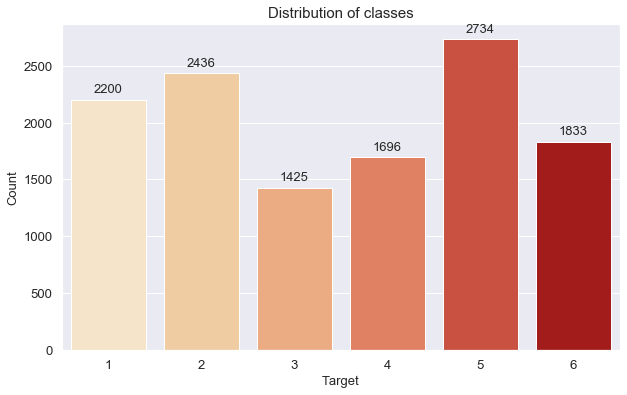

In [3]:
plt.figure(figsize=(10,6))
data=pd.DataFrame(X)
vis1 = sns.countplot(gas_data['TypeOfGas'], palette='OrRd')
plt.title('Distribution of classes', fontsize=15)
plt.xlabel('Target', fontsize=13)
plt.ylabel('Count', fontsize=13)

for p in vis1.patches:
    vis1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=13)

In [4]:
from mpl_toolkits.mplot3d import Axes3D

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:gray']
MARKERS = ['o', 'v', 's', '<', '>', '8', '^', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

def plot2d(X, y_true=None, mode=None, norm_bounds=False):
    transformer = None
    X_r = X
    
    plt.rcParams["figure.figsize"] = (8,5)
    
    if mode is not None:
        transformer = mode(n_components=2)
        X_r = transformer.fit_transform(X)

    assert X_r.shape[1] == 2, 'plot2d only works with 2-dimensional data'

    plt.grid()
    if y_true == None:
        y_true = np.zeros((len(X_r)), dtype=np.int)
    for ix, iyt in zip(X_r, y_true):
        plt.plot(ix[0], ix[1], 
                    c=COLORS[iyt], 
                    marker=MARKERS[0])
    if norm_bounds:
        ax = plt.gca()
        ax.set_xbound(X.min(), X.max())
        ax.set_ybound(X.min(), X.max())

    plt.show()
    
    

# PCA Algorithm

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns; sns.set(style='white')

from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

from pylab import rcParams
rcParams['figure.figsize'] = 9, 9

First of all, we plot the heatmap with the correlations between all the components.

C:\Users\Andreea\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


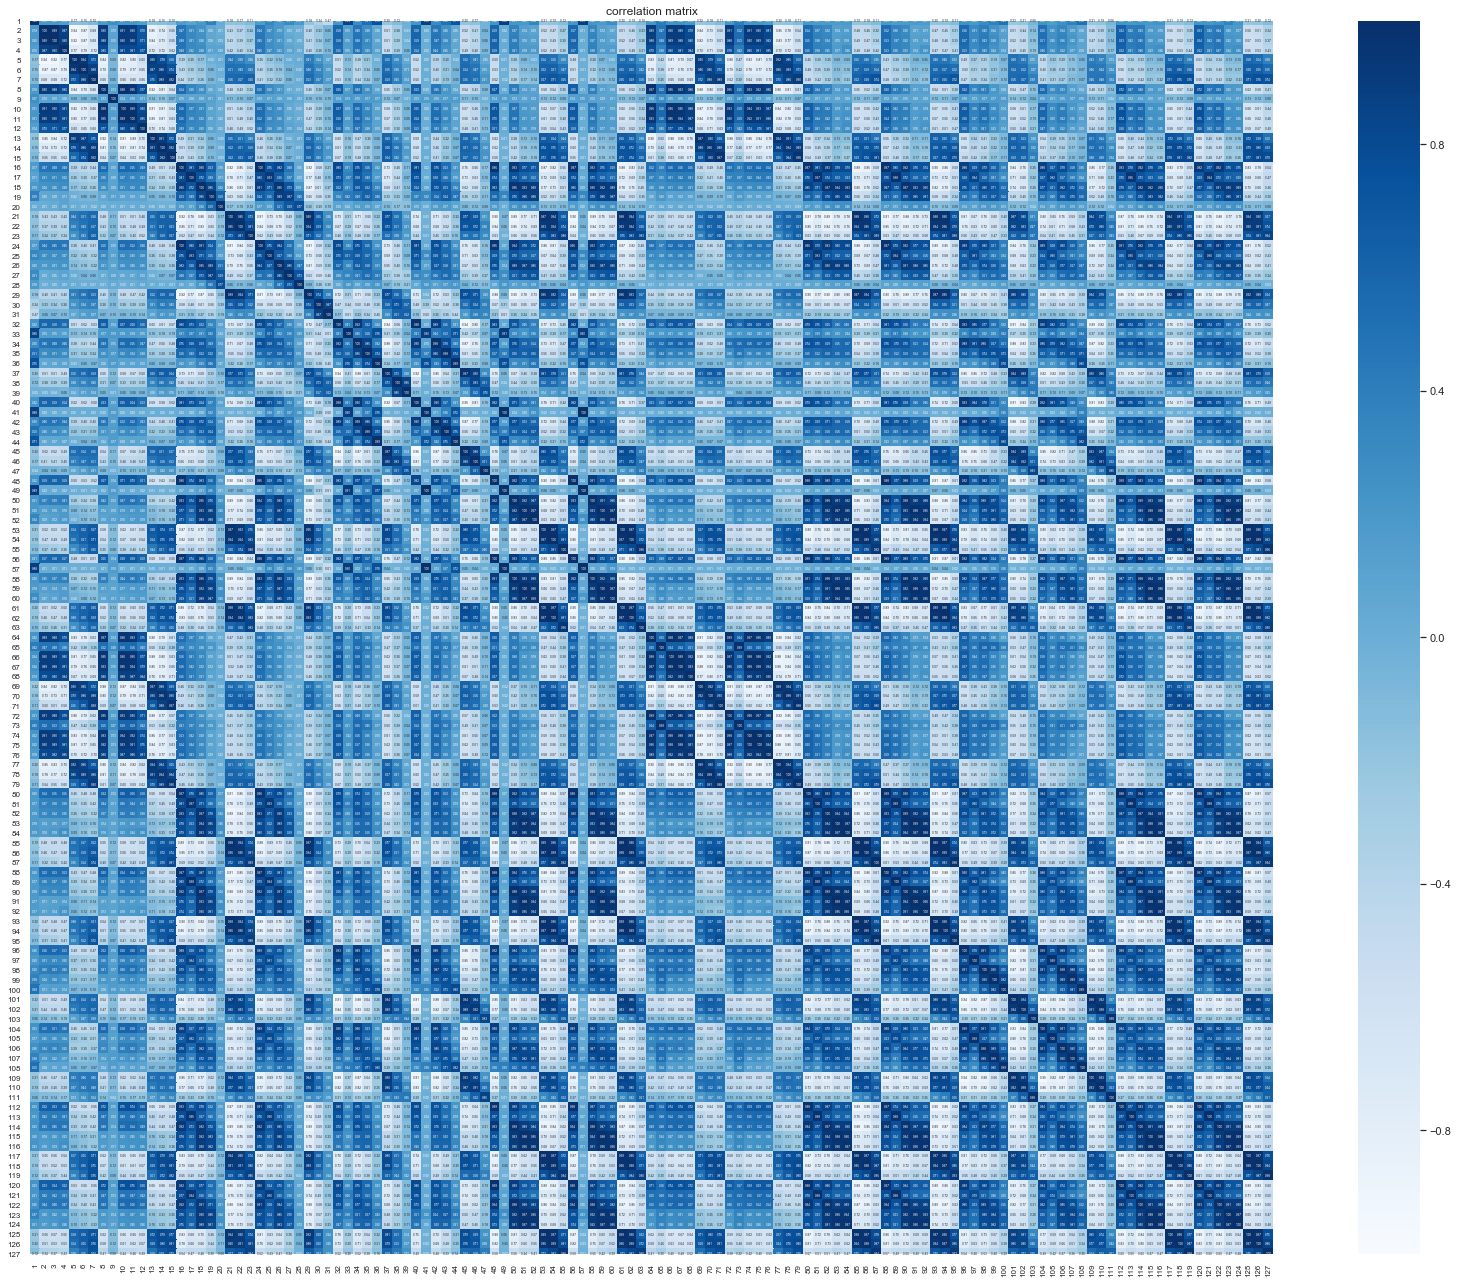

In [7]:
fig, ax = plt.subplots(figsize=(24, 18))

corr = round(data.iloc[:, 1:].corr(),3)
arr_corr = corr.as_matrix()

hm = sns.heatmap(corr, cbar=True, vmin=-1, vmax=1,
                 fmt='.2f', annot_kws={'size': 3}, annot=True, 
                 square=True, cmap=plt.cm.Blues)

ticks = np.arange(corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticks(ticks)
ax.set_yticklabels(corr.index, rotation=360, fontsize=8)

ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

The darker regions have  a positive correlation amongst eachother. 
This means that we may be able to find features on which we can perform PCA projections on. 

The next step is to substract the mean from each feature (data normalization)

In [6]:
import scipy.linalg as la 

def substract_mean(X):
    mean_vector=np.mean(X,axis=0)
    X=X-mean_vector
    return X

def scale_x(X):
    scaler = preprocessing.Normalizer(norm='l2')
    scaler.fit(X)
    scaled_x= scaler.transform(X)
    scaled_x = scaler.transform(X)
    return scaled_x

def cov_matrix(X):
    cov_matrix=np.cov(X, rowvar=False)
    print('The covariance matrix: ')
    print(cov_matrix)
    return cov_matrix

def eig_values_vectors(cov_matrix):
    eigenvalues, eigenvectors=la.eig(cov_matrix)
    print("Eigenvalues")
    print(eigenvalues)
    print("Eigenvectors")
    print(eigenvectors)
    return eigenvalues, eigenvectors

def plot_variance_eig(eigenvalues, eigenvectors,n):
    significance = [np.abs(i)/np.sum(eigenvalues) for i in eigenvalues]
    plt.figure(figsize=(6, 5))
    plt.plot(np.cumsum(significance))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.title('Explained Variance '+str(n))
    plt.savefig("explained_variance.png")
    plt.show()

def plot_cum_variance(eigenvalues, eigenvectors,n):
    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eigenvalues[i]),eigenvectors[:,i]) for i in range(len(eigenvalues))]

    # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eigenvalues)
    var_exp = [(i/tot)*100 for i in sorted(eigenvalues, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES 
    plt.figure(figsize=(6, 5))
    plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='individual explained variance '+str(n), color = 'g')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance '+str(n))
    plt.ylabel('Explained variance ratio ')
    plt.xlabel('Principal components ')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig("explained_variance_with_comp.png", dpi=200)
    plt.show()

def select_eigenvect(eigenvalues, eigenvectors):
    indexes=np.argsort(eigenvalues)[-2:]
    print('The best vectors at index: ') 
    print(indexes)
    vector= eigenvectors[:, indexes]
    return vector

def project_data(X, vector):
    X_prim=np.dot(X,vector)
    plot2d(X_prim)
    return X_prim

In [7]:
#we will work with 2 types of scaled X because we want to see in which case we get better results and compare them
X_norm1=substract_mean(X)
X_norm2=scale_x(X)

#then we calculate the covariance matrix
cov_matrix1=cov_matrix(X_norm1)
cov_matrix2=cov_matrix(X_norm2)

#we calculate the eigenvalues and eigenvectors
eigenvalues1, eigenvectors1=eig_values_vectors(cov_matrix1)
eigenvalues2, eigenvectors2=eig_values_vectors(cov_matrix2)

#select eigenvectors coresponding to the biggest eigenvalues

vector1=select_eigenvect(eigenvalues1, eigenvectors1)
vector2=select_eigenvect(eigenvalues2, eigenvectors2)

The covariance matrix: 
[[ 4.84209518e+09  1.63430026e+05  1.19373813e+06 ... -1.49646069e+05
  -2.51774213e+05 -4.78938203e+05]
 [ 1.63430026e+05  1.86170440e+02  4.49822645e+01 ... -1.20111574e+01
  -2.06226954e+01 -3.68762697e+01]
 [ 1.19373813e+06  4.49822645e+01  3.04304638e+02 ... -3.99526797e+01
  -6.76596319e+01 -1.30473176e+02]
 ...
 [-1.49646069e+05 -1.20111574e+01 -3.99526797e+01 ...  1.68443899e+01
   3.02869373e+01  6.71539803e+01]
 [-2.51774213e+05 -2.06226954e+01 -6.76596319e+01 ...  3.02869373e+01
   5.76281408e+01  1.41327276e+02]
 [-4.78938203e+05 -3.68762697e+01 -1.30473176e+02 ...  6.71539803e+01
   1.41327276e+02  4.71688452e+02]]
The covariance matrix: 
[[ 4.19134300e-02 -2.67672262e-07  1.09824576e-05 ...  2.71427699e-06
   4.90415475e-06  1.27741981e-05]
 [-2.67672262e-07  1.83207422e-08  2.56697680e-09 ... -2.40850968e-10
  -2.17838384e-09 -1.97443753e-08]
 [ 1.09824576e-05  2.56697680e-09  7.46058256e-09 ...  4.82151550e-10
  -1.77732448e-10 -7.14522728e-09]
 

C:\Users\Andreea\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


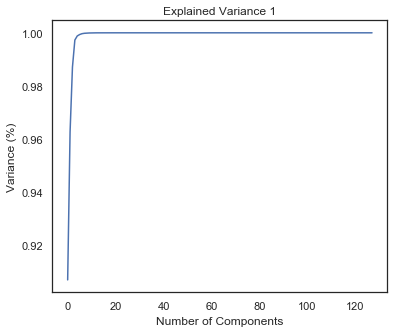

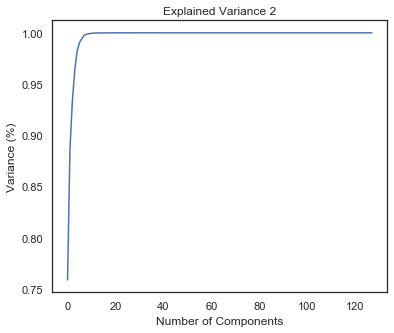

In [8]:
plot_variance_eig(eigenvalues1, eigenvectors1,1)
plot_variance_eig(eigenvalues2, eigenvectors2,2)

We analyze the cumulative variance for both X1 and X2

C:\Users\Andreea\Anaconda3\lib\site-packages\matplotlib\transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


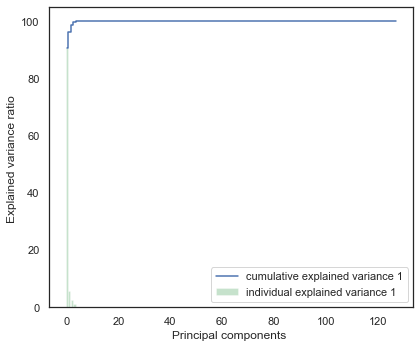

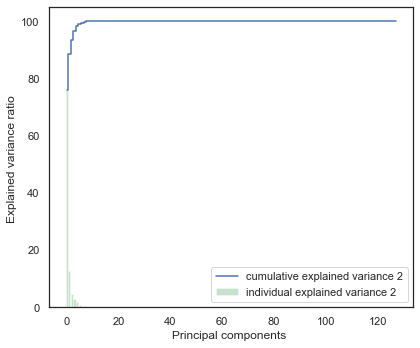

In [9]:
plot_cum_variance(eigenvalues1, eigenvectors2,1)
plot_cum_variance(eigenvalues2, eigenvectors2,2)

Plot the resulted dataset by applying the projection on the initial dataset 

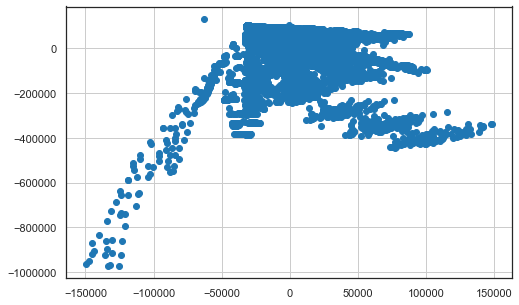

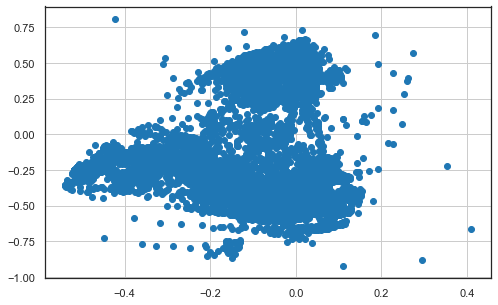

In [10]:
X_prim1=project_data(X_norm1, vector1)
X_prim2=project_data(X_norm2, vector2)

#### Plot the variance using the PCA library

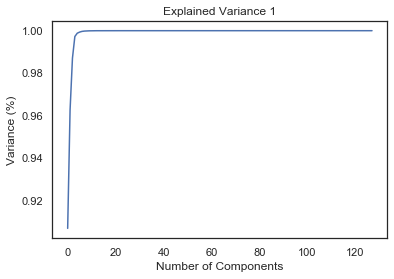

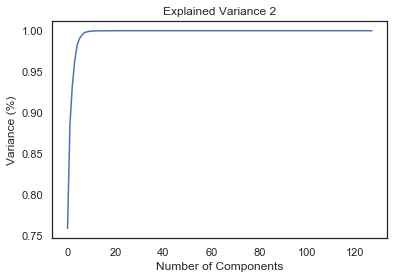

In [11]:
pca1 = PCA()

pca1.fit(X_norm1)
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance '+str(1))
plt.show()


pca2 = PCA()

pca2.fit(X_norm2)
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance '+str(2))
plt.show()



In [12]:
pca1 = PCA(n_components=2)
pca1.fit(X_norm1)
x_pca1 = pca1.transform(X_norm1)
# plt.title('Data after PCA transformation')
# plot2d(x_pca1) 


pca2 = PCA(n_components=2)
pca2.fit(X_norm2)
x_pca2 = pca2.transform(X_norm2)
# plt.title('Data after PCA transformation')
# plot2d(x_pca2)

Text(0, 0.5, 'PCA 2')

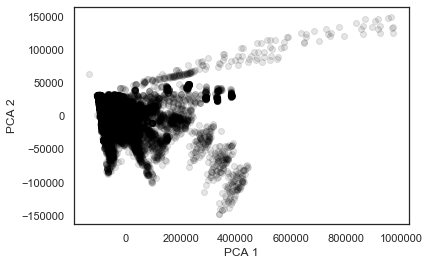

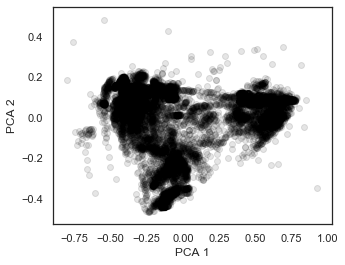

In [13]:
PCA_components1 = pd.DataFrame(x_pca1)
plt.figure()
plt.scatter(PCA_components1[0], PCA_components1[1], alpha=.1, color='black')
plt.rcParams["figure.figsize"] = (5,4)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

PCA_components2 = pd.DataFrame(x_pca2)
plt.figure()
plt.scatter(PCA_components2[0], PCA_components2[1], alpha=.1, color='black')
plt.rcParams["figure.figsize"] = (5,4)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Recover the projected data

In [14]:
def recoverData(Z, U, K):
    """
    Recovers an approximation of the original data when using the projected data
    """
    m,n = Z.shape[0],U.shape[0]
    X_rec = np.zeros((m,n))
    U_reduced = U[:,:K]
    
    for i in range(m):
        X_rec[i,:] = Z[i,:] @ U_reduced.T
    
    return X_rec

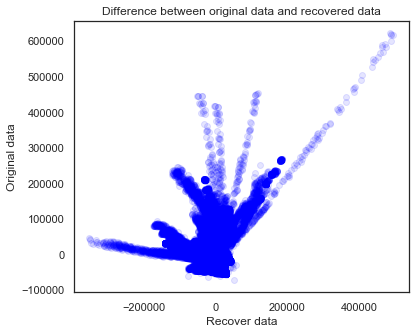

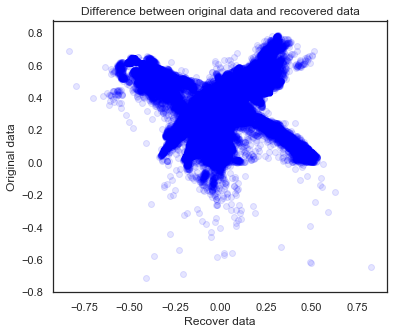

In [15]:
K=2
X_rec1  = recoverData(X_prim1, eigenvectors1, K)

plt.rcParams["figure.figsize"] = (6,5)
plt.figure()
plt.scatter(X_rec1, X_norm1, alpha=.1, color='blue')
plt.xlabel('Recover data')
plt.ylabel('Original data')
plt.title('Difference between original data and recovered data')
plt.show()

X_rec2  = recoverData(X_prim2, eigenvectors2, K)

plt.rcParams["figure.figsize"] = (6,5)
plt.figure()
plt.scatter(X_rec2, X_norm2, alpha=.1, color='blue')
plt.xlabel('Recover data')
plt.ylabel('Original data')
plt.title('Difference between original data and recovered data')
plt.show()


The PCA algorithm gives good results because the recovered data and the original data have many data points in common. This means that reducing the dimension to only 2 principal components doesn't bring loss of original data.

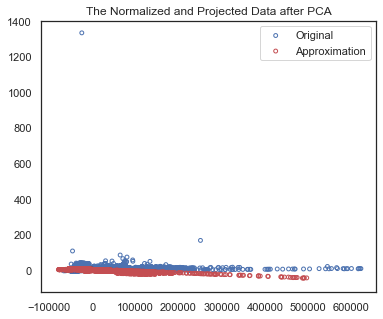

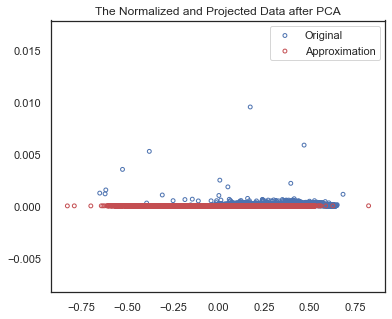

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(X_norm1[:,0],X_norm1[:,1],marker="o",label="Original",facecolors="none",edgecolors="b",s=15)
plt.scatter(X_rec1[:,0],X_rec1[:,1],marker="o",label="Approximation",facecolors="none",edgecolors="r",s=15)
plt.title("The Normalized and Projected Data after PCA")
plt.legend()


plt.figure(figsize=(6, 5))
plt.scatter(X_norm2[:,0],X_norm2[:,1],marker="o",label="Original",facecolors="none",edgecolors="b",s=15)
plt.scatter(X_rec2[:,0],X_rec2[:,1],marker="o",label="Approximation",facecolors="none",edgecolors="r",s=15)
plt.title("The Normalized and Projected Data after PCA")
plt.legend()


#### Comparing the results, we can clearly see that PCA gives better results with scaled data and it can recover the data to its original form much better than the normalized data with mean subtraction. For the further implementation, we stick to X_norm2.

# K-Means Algorithm

Choosing K is one of the most important aspects in k-Means algorithm and I did it with the following methods:

In [17]:
X_scaled=X_norm2

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, minimizing a criterion known as the inertia or within-cluster sum-of-squares Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are.

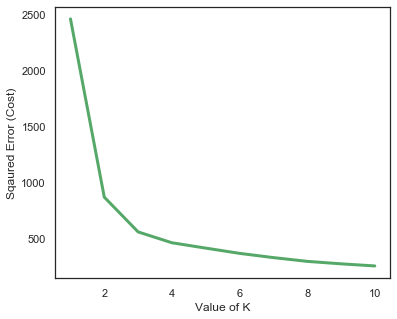

In [18]:
#choose k with Elbow Method
from sklearn.cluster import KMeans 

cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(X_scaled) 
    cost.append(KM.inertia_)      

plt.figure(figsize=(6,5))
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()
#as we can see, the optimal k numbers of clusters is 2 or 3

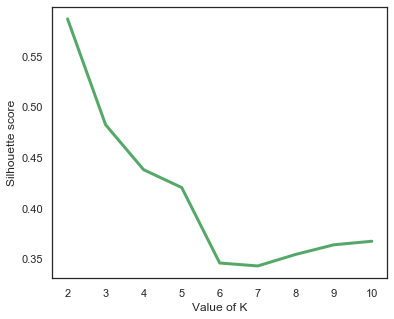

In [19]:
#Choose k with Silhouete method
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))

plt.figure(figsize=(6,5))
plt.plot(range(2, 11), sil, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score") 
plt.show()
# 2 is the best in this case

In [20]:
print(sil)

[0.5868861528573923, 0.48219763048123193, 0.4376895047665934, 0.4200959377985679, 0.3454393757232805, 0.3425302956627699, 0.35396497685720896, 0.3634542344290915, 0.36695431570729303]



  - here we have plotted data in 2D with PCA, using the initial set of data

In [21]:
def plot2dcluster(X, y_pred, y_true, mode=None, centroids=None):
    transformer = None
    X_r = X
    
    if mode is not None:
        transformer = mode(n_components=2)
        X_r = transformer.fit_transform(X)

    assert X_r.shape[1] == 2, 'plot2d only works with 2-dimensional data'


    plt.grid()
    for ix, iyp, iyt in zip(X_r, y_pred, y_true):
        plt.plot(ix[0], ix[1], 
                    c=COLORS[iyp], 
                    marker=MARKERS[iyt])
        
    if centroids is not None:
        C_r = centroids
        if transformer is not None:
            C_r = transformer.fit_transform(centroids)
        for cx in C_r:
            plt.plot(cx[0], cx[1], 
                        marker=MARKERS[-1], 
                        markersize=10,
                        c='red')

    plt.show()

Clustering the initial data
2D plot with number of clusters: 2


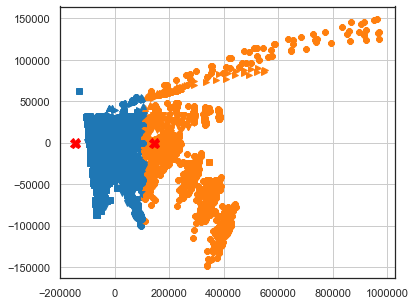

2D plot with number of clusters: 3


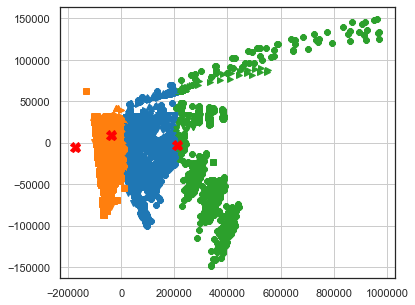

In [22]:
from sklearn.decomposition import PCA
chosen_k=3
print("Clustering the initial data")
for k in range(2, chosen_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    print('2D plot with number of clusters: %d'%(k))
    plot2dcluster(X, kmeans.labels_, y, mode=PCA, centroids=kmeans.cluster_centers_)

- and here we have plotted data with scaled_x

Clustering the normalized data
2D plot with number of clusters: 2


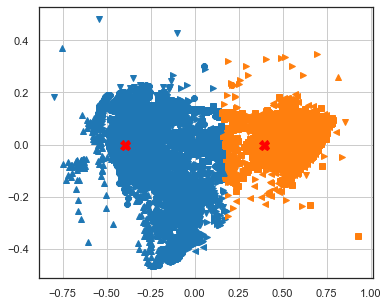

2D plot with number of clusters: 3


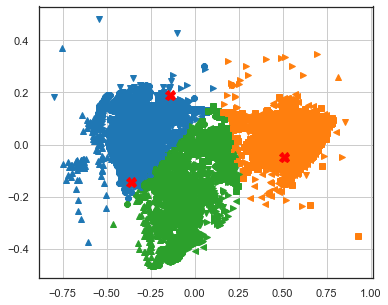

In [23]:
from sklearn.decomposition import PCA

chosen_k=3
print("Clustering the normalized data")
for k in range(2, chosen_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    print('2D plot with number of clusters: %d'%(k))
    plot2dcluster(X_scaled, kmeans.labels_, y, mode=PCA, centroids=kmeans.cluster_centers_)

### Now we want to plot the clusters with data direclty transformed to 2 principal components

Clustering the dimensionality reduced data
2D plot with number of clusters: 2


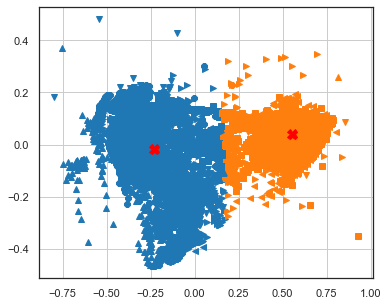

2D plot with number of clusters: 3


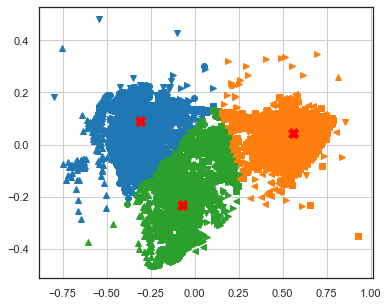

In [24]:
chosen_k=3
print("Clustering the dimensionality reduced data")
for k in range(2, chosen_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(x_pca2)
    print('2D plot with number of clusters: %d'%(k))
    plot2dcluster(x_pca2, kmeans.labels_, y, centroids=kmeans.cluster_centers_)

As far as we can see, the data transformed with PCA algorithm seems to give the best results, because the centroids are well placed. Now we will use N iterations for each case to compare the Distance Between clusters and the Distance Within clusters.

- The distance WC should be minimised
- The distance BC should be maximised

In [127]:
results_clustering = pd.DataFrame(columns = ["Algorithm","Data","Distance BC - Maximized","Distance WC - Minimised", "N-clusters"])

In [26]:
def calculate_wc(points,assignments,kmeans):
    n_clusters=kmeans.n_clusters
    centers=kmeans.cluster_centers_
    avg=[]
    wc=0
    axes_to_sum=tuple(np.arange(1,points.ndim))
    for i in range(n_clusters):
        examples_in_cluster=points[assignments==i]
        for example in examples_in_cluster:
            wc+=np.sum(np.sqrt(np.sum((examples_in_cluster-example)**2,axis=axes_to_sum)))
    return wc/2

#this is intertia

In [27]:
def calculate_bc(points,assignments,kmeans):
    n_clusters=kmeans.n_clusters
    centers=kmeans.cluster_centers_
    avg=[]
    bc=0
    axes_to_sum=tuple(np.arange(1,points.ndim))
    for i in range(n_clusters):
        examples_in_cluster=points[assignments==i]
        examples_notin_cluster=points[assignments!=i]
        for example in examples_in_cluster:
            bc+=np.sum(np.sqrt(np.sum((examples_notin_cluster-example)**2,axis=axes_to_sum)))
    return bc/2
   

In [28]:
final_wc=[]
final_bc=[]

In [29]:
wc1=[]
bc1=[]
kmax=3
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X)
    wc1.append(calculate_wc(X, kmeans.labels_, kmeans))
    bc1.append(calculate_bc(X, kmeans.labels_, kmeans))
    
print(wc1)
print(bc1)

[4326663024727.119, 2489076875948.0947]
[5212318191483.358, 7049904340262.396]


In [41]:
wc1_best=np.min(wc1)
bc1_best=np.max(bc1)
index=np.argmin(wc1)
i=np.argmax(bc1)
if index==0:
    n_cl1=2
else:
    n_cl1=3

In [31]:
wc2=[]
bc2=[]
kmax=3
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X_scaled)
    wc2.append(calculate_wc(X_scaled, kmeans.labels_, kmeans))
    bc2.append(calculate_bc(X_scaled, kmeans.labels_, kmeans))
    
print(wc2)
print(bc2)

[15364720.396214684, 7367996.435589538]
[26775323.89029709, 34772047.85092207]


In [42]:
wc2_best=np.min(wc2)
bc2_best=np.max(bc2)
index=np.argmin(wc3)
i=np.argmax(bc3)
if index==0:
    n_cl2=2
else:
    n_cl2=3

In [33]:
wc3=[]
bc3=[]
kmax=3
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(x_pca2)
    wc3.append(calculate_wc(x_pca2, kmeans.labels_, kmeans))
    bc3.append(calculate_bc(x_pca2, kmeans.labels_, kmeans))
    
print(wc3)
print(bc3)

[12294795.408379935, 4996309.970233147]
[25812663.177770324, 33111148.61591725]


In [44]:
wc3_best=np.min(wc3)
bc3_best=np.max(bc3)
index=np.argmin(wc3)
i=np.argmax(bc3)
if index==0:
    n_cl3=2
else:
    n_cl3=3

In [128]:
results_clustering.loc[len(results_clustering)] = ["K-Means","Raw data", wc1_best, bc1_best,n_cl1]
results_clustering.loc[len(results_clustering)] = ["K-Means","Normalized data", wc2_best, bc2_best,n_cl2]
results_clustering.loc[len(results_clustering)] = ["K-Means","2 Dimensioned data with PCA ", wc3_best, bc3_best, n_cl3]

In [129]:
results_clustering

,Algorithm,Data,Distance BC - Maximized,Distance WC - Minimised,N-clusters
0,K-Means,Raw data,2.489077e+12,7.049904e+12,3
1,K-Means,Normalized data,7.367996e+06,3.477205e+07,3
2,K-Means,2 Dimensioned data with PCA,4.996310e+06,3.311115e+07,3


### As we can see, the Normalized data and the 2 Dimensioned data gives the best results for WC and BC. That' s why we should test them in the following steps and eventually choose between them.

### I will analyze the BC and WC distance using 3 centroids 

In [50]:
results_samples = pd.DataFrame(columns = ["Data","Centroid attempt","Iteration" ,"Inertia","Centroids"])

In [51]:
results_samples

,Data,Centroid attempt,Iteration,Inertia,Centroids


In [52]:
total_results_samples=pd.DataFrame(columns = ["Data","Centroid attempt","Best inertia" ,"Best centroids","Best labels","Initial intertia - Final inertia"])

## For the 2 dimensioned data with PCA

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.

Inertia can be recognized as a measure of how internally coherent clusters are.

In [53]:
final_cents = []
final_inert = []
initial_centroids=[]
diff_inertia=[]
best_cents=[]
best_labels=[]
for sample in range(5):
    print('\nCentroid attempt: ', sample)
    km = KMeans(n_clusters=3, init='random', max_iter=1, n_init=1)
    km.fit(x_pca2)
    inertia_start = km.inertia_
    intertia_end = 0
    cents = km.cluster_centers_
    labels=km.labels_
    sample_inertia=[]
    sample_labels=[]
    sample_inertia.append(inertia_start)
    final_cents.append(cents)
    sample_labels.append(labels)
    for iter in range(10):
        km = KMeans(n_clusters=3, init=cents, max_iter=1, n_init=1)
        km.fit(x_pca2)
        inertia_end = km.inertia_
        end_labels=km.labels_
        sample_inertia.append(inertia_end)
        sample_labels.append(end_labels)
        cents = km.cluster_centers_
        final_inert.append(inertia_end)
        final_cents.append(cents)
        results_samples.loc[len(results_samples)] = ["2 Dim data", sample, iter, str(inertia_end), str(cents)]
    print(results_samples)
    results_samples = pd.DataFrame(columns = ["Data","Centroid attempt","Iteration" ,"Inertia","Centroids"])
    best_intertia=np.argmin(sample_inertia)
    best_cents.append(final_cents[best_intertia])
    best_labels.append(sample_labels[best_intertia])

    diff_inertia.append(inertia_start-inertia_end)
    total_results_samples.loc[len(total_results_samples)] = ["2 Dim data", sample, np.min(sample_inertia), final_cents[best_intertia],sample_labels[best_intertia],str(inertia_start-inertia_end)]

print(total_results_samples)


Centroid attempt:  0
         Data Centroid attempt Iteration             Inertia  \
0  2 Dim data                0         0   536.9108073944367   
1  2 Dim data                0         1   531.7755891809527   
2  2 Dim data                0         2   527.9470329426379   
3  2 Dim data                0         3    525.418594420461   
4  2 Dim data                0         4   523.7654309619273   
5  2 Dim data                0         5    522.080213712605   
6  2 Dim data                0         6   518.4098326636066   
7  2 Dim data                0         7  508.42165439309696   
8  2 Dim data                0         8   457.1517996930923   
9  2 Dim data                0         9   303.3238084094287   

                                           Centroids  
0  [[ 0.65263297  0.05827139]\n [ 0.43315686  0.0...  
1  [[ 0.64271046  0.04819604]\n [ 0.39421464  0.0...  
2  [[ 0.63209679  0.04526309]\n [ 0.35954197  0.0...  
3  [[ 0.62477386  0.04467105]\n [ 0.32941269  0.0... 

In [54]:
total_results_samples

,Data,Centroid attempt,Best inertia,Best centroids,Best labels,Initial intertia - Final inertia
0,2 Dim data,0,303.323808,"[[0.5785437165407409, 0.04484819009212891], [0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",248.03899625028578
1,2 Dim data,1,277.404143,"[[0.6131310361913799, 0.044146836781790745], [...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",222.10523267320207
2,2 Dim data,2,277.404143,"[[0.6034848690932759, 0.0448187564640982], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",134.76916865834988
3,2 Dim data,3,277.404143,"[[0.5920568189197254, 0.04618481104999556], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1001.9145177067652
4,2 Dim data,4,278.464944,"[[0.5785437165407409, 0.04484819009212891], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",271.75012158016415


Plotting data with best labels: 
[2 2 2 ... 1 1 1]
and best centroids: 
[[ 0.57854372  0.04484819]
 [ 0.00481886 -0.20569847]
 [-0.29194087  0.04716759]]


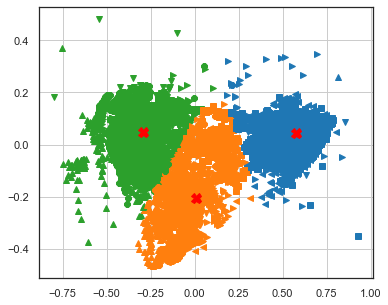

Plotting data with best labels: 
[2 2 2 ... 1 1 1]
and best centroids: 
[[ 0.61313104  0.04414684]
 [ 0.2825932   0.00267621]
 [-0.24608489 -0.01518726]]


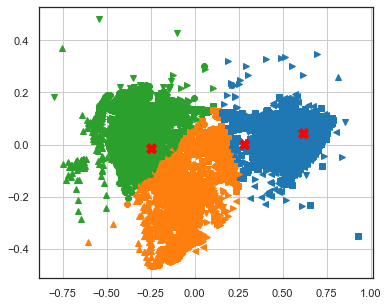

Plotting data with best labels: 
[0 0 0 ... 1 1 1]
and best centroids: 
[[ 0.60348487  0.04481876]
 [ 0.21465562 -0.04381798]
 [-0.25337447 -0.00961722]]


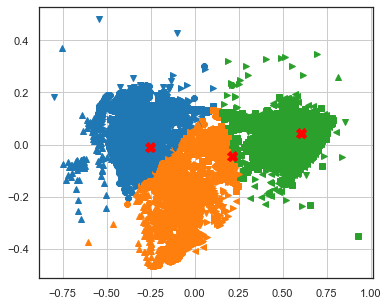

Plotting data with best labels: 
[0 0 0 ... 2 2 2]
and best centroids: 
[[ 0.59205682  0.04618481]
 [ 0.13879606 -0.09915638]
 [-0.26193647 -0.00147952]]


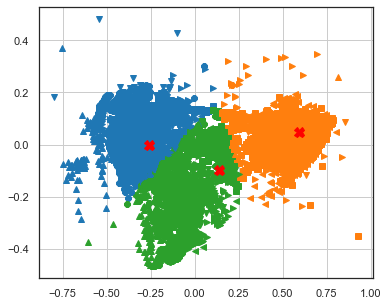

Plotting data with best labels: 
[0 0 0 ... 2 2 2]
and best centroids: 
[[ 0.57854372  0.04484819]
 [ 0.00481886 -0.20569847]
 [-0.29194087  0.04716759]]


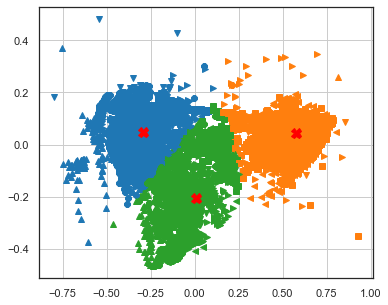

In [55]:
# best_cents=np.array(best_cents)
# best_labels=np.array(best_labels)
for it in range(5):
    print('Plotting data with best labels: ')
    print(best_labels[it])
    print('and best centroids: ')
    print(best_cents[it])
    plot2dcluster(x_pca2, best_labels[it], y, centroids=best_cents[it])

Plotting the distances obtained:
- the distance within clusters (the distance should be minimised)
- the distance between clusters (the distance should be maximised)

The performance of the clustering is given by the W(C) distance or by the B(C).

Verifying the output:

The next step is to verify the prediction of data

In [70]:
from sklearn.model_selection import train_test_split

In [105]:
X_train, X_test, y_train, y_test = train_test_split(x_pca2, y, test_size=0.3, random_state=101)

In [107]:
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
kmeans.fit(X_train)
pred1 = kmeans.predict(X_test)

In [108]:
frame = pd.DataFrame(X_test)
frame['cluster'] = pred1
counts=np.array(frame['cluster'].value_counts())
counts

array([1737, 1077,  884], dtype=int64)

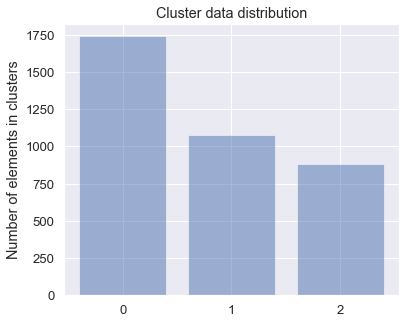

In [109]:
y_pos_counts=np.arange(len(counts))

plt.figure(figsize=(6,5))
plt.bar(y_pos_counts, counts, align='center', alpha=0.5)
plt.xticks(y_pos_counts)
plt.ylabel('Number of elements in clusters')
plt.title('Cluster data distribution')

plt.show()

# For the Normalized data 

In [60]:
results_samples_norm = pd.DataFrame(columns = ["Data","Centroid attempt","Iteration" ,"Inertia","Centroids"])

In [61]:
total_results_samples_norm=pd.DataFrame(columns = ["Data","Centroid attempt","Best inertia" ,"Best centroids","Best labels","Initial intertia - Final inertia"])

In [62]:
final_cents = []
final_inert = []
initial_centroids=[]
diff_inertia=[]
best_cents=[]
best_labels=[]
for sample in range(5):
    print('\nCentroid attempt: ', sample)
    km = KMeans(n_clusters=3, init='random', max_iter=1, n_init=1)
    km.fit(X_scaled)
    inertia_start = km.inertia_
    intertia_end = 0
    cents = km.cluster_centers_
    labels=km.labels_
    sample_inertia=[]
    sample_labels=[]
    sample_inertia.append(inertia_start)
    final_cents.append(cents)
    sample_labels.append(labels)
    for iter in range(10):
        km = KMeans(n_clusters=3, init=cents, max_iter=1, n_init=1)
        km.fit(X_scaled)
        inertia_end = km.inertia_
        end_labels=km.labels_
        sample_inertia.append(inertia_end)
        sample_labels.append(end_labels)
        cents = km.cluster_centers_
        final_inert.append(inertia_end)
        final_cents.append(cents)
        results_samples_norm.loc[len(results_samples_norm)] = ["Normalized data", sample, iter, str(inertia_end), str(cents)]
    print(results_samples_norm)
    results_samples_norm = pd.DataFrame(columns = ["Data","Centroid attempt","Iteration" ,"Inertia","Centroids"])
    best_intertia=np.argmin(sample_inertia)
    diff_inertia.append(inertia_start-inertia_end)
    best_cents.append(final_cents[best_intertia])
    best_labels.append(sample_labels[best_intertia])
    total_results_samples_norm.loc[len(total_results_samples_norm)] = ["Normalized data", sample, np.min(sample_inertia), final_cents[best_intertia],sample_labels[best_intertia],str(inertia_start-inertia_end)]

print(total_results_samples_norm)


Centroid attempt:  0
              Data Centroid attempt Iteration            Inertia  \
0  Normalized data                0         0  555.6138436975955   
1  Normalized data                0         1  554.6092342168588   
2  Normalized data                0         2  554.4265633474173   
3  Normalized data                0         3  554.4088684224951   
4  Normalized data                0         4  554.4044516184928   
5  Normalized data                0         5  554.4040737762674   
6  Normalized data                0         6  554.4040737762674   
7  Normalized data                0         7  554.4040737762674   
8  Normalized data                0         8  554.4040737762674   
9  Normalized data                0         9  554.4040737762674   

                                           Centroids  
0  [[ 1.56266297e-01  7.00930881e-05  4.01763042e...  
1  [[ 1.68155759e-01  6.98399664e-05  4.37830274e...  
2  [[ 1.73364885e-01  6.97758737e-05  4.52216020e...  
3  [[ 1.7

In [63]:
total_results_samples_norm

,Data,Centroid attempt,Best inertia,Best centroids,Best labels,Initial intertia - Final inertia
0,Normalized data,0,554.404074,"[[0.17598542455236826, 6.969306932106969e-05, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",8.248222949371439
1,Normalized data,1,554.404074,"[[0.17598542455236826, 6.969306932106969e-05, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",426.60815955634416
2,Normalized data,2,793.021049,"[[0.17598542455236826, 6.969306932106969e-05, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",30.188930191897953
3,Normalized data,3,554.404043,"[[0.17598542455236826, 6.969306932106969e-05, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",33.67104997156957
4,Normalized data,4,792.167725,"[[0.17598542455236826, 6.969306932106969e-05, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40.934507503621035


In [64]:
best_labels

[array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([2, 2, 2, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0])]

Plotting from each iteration: 


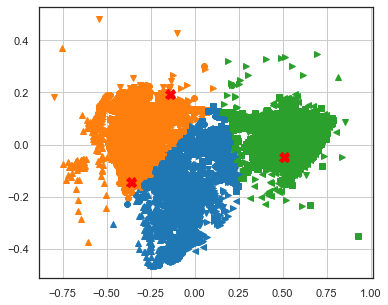

Plotting from each iteration: 


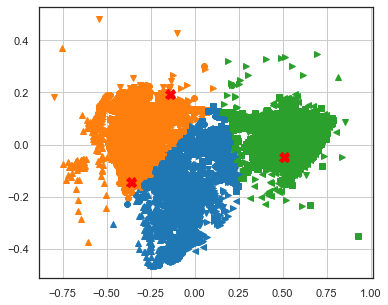

Plotting from each iteration: 


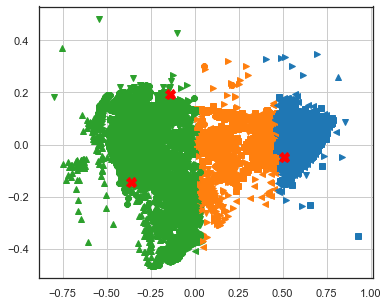

Plotting from each iteration: 


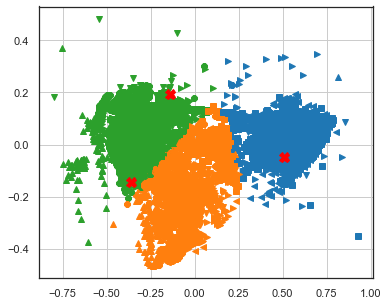

Plotting from each iteration: 


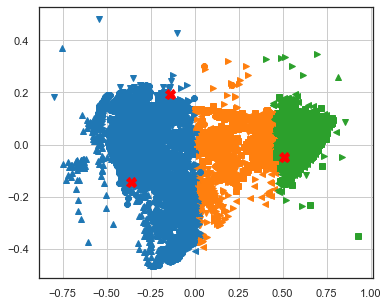

In [65]:
for it in range(5):
    print('Plotting from each iteration: ')
    plot2dcluster(X_scaled, best_labels[it], y, centroids=best_cents[it], mode=PCA)

In [114]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

In [115]:
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
kmeans.fit(X_train_n)
pred_kmeans = kmeans.predict(X_test_n)

In [116]:
frame_2 = pd.DataFrame(X_test_n)
frame_2['cluster'] = pred_kmeans
counts2=np.array(frame_2['cluster'].value_counts())
counts2

array([1730, 1074,  894], dtype=int64)

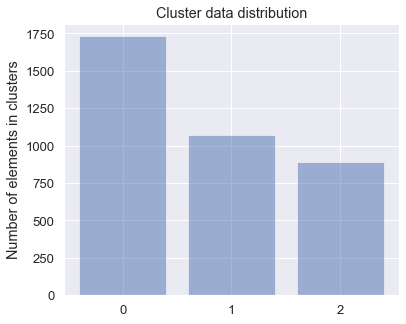

In [117]:
y_pos_counts2=np.arange(len(counts2))

plt.figure(figsize=(6,5))
plt.bar(y_pos_counts2, counts2, align='center', alpha=0.5)
plt.xticks(y_pos_counts2)
plt.ylabel('Number of elements in clusters')
plt.title('Cluster data distribution')

plt.show()

In [118]:
frames=[total_results_samples,total_results_samples_norm]

In [119]:
final_results=pd.concat(frames)

In [120]:
final_results

,Data,Centroid attempt,Best inertia,Best centroids,Best labels,Initial intertia - Final inertia
0,2 Dim data,0,303.323808,"[[0.5785437165407409, 0.04484819009212891], [0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",248.03899625028578
1,2 Dim data,1,277.404143,"[[0.6131310361913799, 0.044146836781790745], [...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",222.10523267320207
2,2 Dim data,2,277.404143,"[[0.6034848690932759, 0.0448187564640982], [0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",134.76916865834988
3,2 Dim data,3,277.404143,"[[0.5920568189197254, 0.04618481104999556], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1001.9145177067652
4,2 Dim data,4,278.464944,"[[0.5785437165407409, 0.04484819009212891], [0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",271.75012158016415
0,Normalized data,0,554.404074,"[[0.17598542455236826, 6.969306932106969e-05, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",8.248222949371439
1,Normalized data,1,554.404074,"[[0.17598542455236826, 6.969306932106969e-05, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",426.60815955634416
2,Normalized data,2,793.021049,"[[0.17598542455236826, 6.969306932106969e-05, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",30.188930191897953
3,Normalized data,3,554.404043,"[[0.17598542455236826, 6.969306932106969e-05, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",33.67104997156957
4,Normalized data,4,792.167725,"[[0.17598542455236826, 6.969306932106969e-05, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40.934507503621035


## Plotting WC and BC for each type of data to see the differences

In [69]:
wc_total=[]
wc_total.append(wc1)
wc_total.append(wc2)
wc_total.append(wc3)

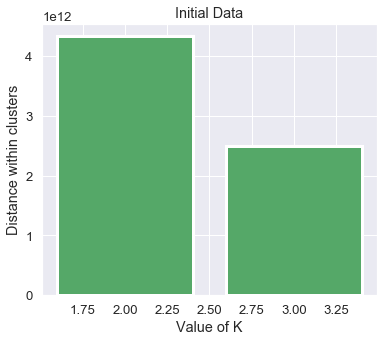

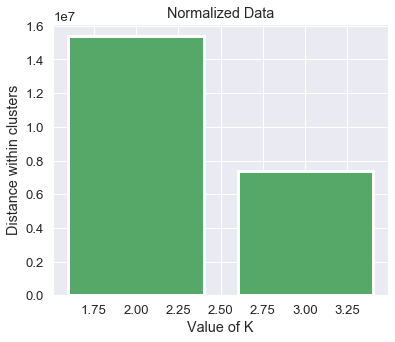

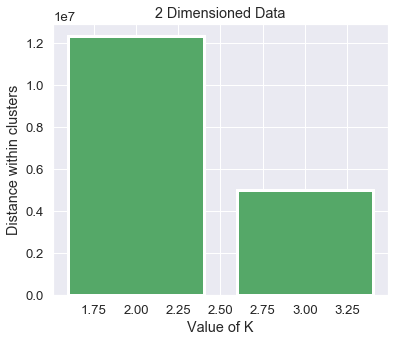

In [126]:
y_pos_wc1=[2,3]
plt.bar(y_pos_wc1, wc1, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Distance within clusters") 
plt.title("Initial Data")
plt.show()

y_pos_wc2=[2,3]
plt.bar(y_pos_wc2, wc2, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Distance within clusters") 
plt.title("Normalized Data")
plt.show()

y_pos_wc3=[2,3]
plt.bar(y_pos_wc3, wc3, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Distance within clusters") 
plt.title("2 Dimensioned Data")
plt.show()

# plt.plot(range(2, 4), bc1, color ='r', linewidth ='3') 
# plt.xlabel("Value of K") 
# plt.ylabel("Distance between clusters") 
# plt.show()

# DBSCAN

In [132]:
from sklearn.cluster import DBSCAN

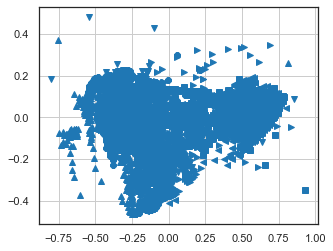

In [20]:
dbscan = DBSCAN(eps=1, min_samples=5).fit(x_pca2)


plot2dcluster(x_pca2, dbscan.labels_, y)

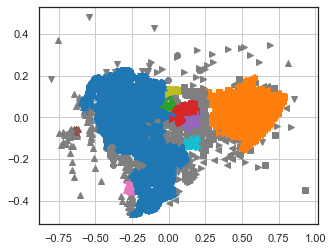

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1

In [98]:
dbscan1 = DBSCAN(eps=0.02, min_samples=10, metric='euclidean').fit(x_pca2)

plot2dcluster(x_pca2, dbscan1.labels_, y)

dbscan.labels_[0:300]


In [53]:
dbscan = DBSCAN(eps=0.1, min_samples=10, metric='euclidean').fit(X_scaled)
dbscan.labels_[0:300]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1

### Implementing dbscan with metric *ecliudean* 

In [234]:
#aici.....
eps=[0.1, 0.2, 0.01, 0.02]
min_samples=[3,4,5,6,7,8,9,10]
alg='ball_tree'
total=len(eps)*len(min_samples)

def func1(points,eps,min_samples, total):
    low_res=0
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j],algorithm=alg).fit(points)
            assignments=dbscan.labels_
            n_clusters=(np.max(assignments)+1)
            print(assignments)         
            wc_dbscan=calculate_wc(points,assignments, kmeans)
            sb_dbscan=calculate_bc(points,assignments,kmeans)
            if n_clusters<=1:
                low_res+=1
            print('Number of clusters for eps: %5.2f and min_sample: %d, WC is: %d and BC %d is: %d'%(eps[i], min_samples[j],wc_dbscan,sb_dbscan,n_clusters))
            #inertia dist de la punct la clusterul lui
            #grafic cu inertia
    procent=(float(low_res)/float(total))*100
    print('The percent of total have n_cluster <=1: {} %'.format(procent))

kmeans = KMeans(n_clusters = 3).fit(x_pca2)
func1(x_pca2, eps,min_samples, total)


[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 3, WC is: 38036210 and BC 35613 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 4, WC is: 38030034 and BC 38699 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 5, WC is: 37979067 and BC 64155 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 6, WC is: 37970455 and BC 68456 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 7, WC is: 37970455 and BC 68456 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 8, WC is: 37961252 and BC 73050 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 9, WC is: 37961252 and BC 73050 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.10 and min_sample: 10, WC is: 37961252 and BC 73050 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:  0.20 and min_sample: 3, WC is: 38085328 and BC 11063 is: 1
[0 0 0 ... 0 0 0]
Number of clusters for eps:

As we can see, a half from all gives only 1 cluster so we are going to eliminate the values from epsilon which are: 0.1, 0.2, 0.3

Epsilon is the maximum distance between two samples for them to be considered as in the same neighborhood.

In [133]:
dbscan_results = pd.DataFrame(columns = ["Data","Clusters","Epsilon","Algorithm" ,"WC","BC"])

In [135]:
eps=[0.01, 0.02, 0.03, 0.04, 0.05]
min_samples=[3,4,5,6,7,8,9,10]
alg='ball_tree'


def func1(points,eps,min_samples, alg):
    wc=[]
    bc=[]
    epsilon=[]
    clusters=[]
    results=[]
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j],algorithm=alg).fit(points)
            assignments=dbscan.labels_
            n_clusters=(np.max(assignments)+1)
                    
            wc_dbscan=calculate_wc(points,assignments, kmeans)
            bc_dbscan=calculate_bc(points,assignments,kmeans)
            wc.append(wc_dbscan)
            bc.append(bc_dbscan)
            epsilon.append(eps[i])
            clusters.append(n_clusters)
#             print('Number of clusters for eps: %5.2f and min_sample: %d, WC is: %d and BC %d is: %d'%(eps[i], min_samples[j],wc_dbscan,bc_dbscan,n_clusters))
            #inertia dist de la punct la clusterul lui
            #grafic cu inertia
    best_wc=np.argmin(wc)
    best_bc=np.argmax(bc)
    print(best_wc)
    dbscan_results.loc[len(dbscan_results)] = ["PCA data", clusters[best_bc], epsilon[best_bc], alg, wc[best_bc], bc[best_bc]]
    return dbscan_results


kmeans = KMeans(n_clusters = 3).fit(x_pca2)
result1=func1(x_pca2, eps,min_samples, alg)

7


In [136]:
result1

,Data,Clusters,Epsilon,Algorithm,WC,BC
0,PCA data,10,0.02,ball_tree,1.035373e+07,2.563453e+07


In [ ]:
# results_samples_norm.loc[len(results_samples_norm)] = ["Normalized data", sample, iter, str(inertia_end), str(cents)]

In [137]:
eps=[0.01, 0.02, 0.03, 0.04, 0.05]
min_samples=[3,4,5,6,7,8,9,10]
alg='kd_tree'
total=len(eps)*len(min_samples)

def func1(points,eps,min_samples, total, dbscan_results):
    wc=[]
    bc=[]
    epsilon=[]
    clusters=[]
    results=[]
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j],algorithm=alg).fit(points)
            assignments=dbscan.labels_
            n_clusters=(np.max(assignments)+1)
                    
            wc_dbscan=calculate_wc(points,assignments, kmeans)
            bc_dbscan=calculate_bc(points,assignments,kmeans)
            wc.append(wc_dbscan)
            bc.append(bc_dbscan)
            epsilon.append(eps[i])
            clusters.append(n_clusters)
#            print('Number of clusters for eps: %5.2f and min_sample: %d, WC is: %d and BC %d is: %d'%(eps[i], min_samples[j],wc_dbscan,bc_dbscan,n_clusters))
            #inertia dist de la punct la clusterul lui
            #grafic cu inertia
    best_wc=np.argmin(wc)
    best_bc=np.argmax(bc)
   
    dbscan_results.loc[len(dbscan_results)] = ["PCA data", clusters[best_bc], epsilon[best_bc], alg, wc[best_bc], bc[best_bc]]
    return dbscan_results


kmeans = KMeans(n_clusters = 3).fit(x_pca2)
result2=func1(x_pca2, eps,min_samples, total,dbscan_results)

In [138]:
result2

,Data,Clusters,Epsilon,Algorithm,WC,BC
0,PCA data,10,0.02,ball_tree,1.035373e+07,2.563453e+07
1,PCA data,10,0.02,kd_tree,1.035373e+07,2.563453e+07


In [139]:
eps=[0.01, 0.02, 0.03, 0.04, 0.05]
min_samples=[3,4,5,6,7,8,9,10]
alg='brute'

def func1(points,eps,min_samples,dbscan_results):
    wc=[]
    bc=[]
    epsilon=[]
    clusters=[]
    results=[]
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j],algorithm=alg).fit(points)
            assignments=dbscan.labels_
            n_clusters=(np.max(assignments)+1)
                  
            wc_dbscan=calculate_wc(points,assignments, kmeans)
            bc_dbscan=calculate_bc(points,assignments,kmeans)
            wc.append(wc_dbscan)
            bc.append(bc_dbscan)
            epsilon.append(eps[i])
            clusters.append(n_clusters)
#             print('Number of clusters for eps: %5.2f and min_sample: %d, WC is: %d and BC %d is: %d'%(eps[i], min_samples[j],wc_dbscan,bc_dbscan,n_clusters))
            #inertia dist de la punct la clusterul lui
            #grafic cu inertia
    best_wc=np.argmin(wc)
    best_bc=np.argmax(bc)
    
    dbscan_results.loc[len(dbscan_results)] = ["PCA data", clusters[best_bc], epsilon[best_bc], alg, wc[best_bc], bc[best_bc]]
    return dbscan_results


kmeans = KMeans(n_clusters = 3).fit(x_pca2)
result3=func1(x_pca2, eps,min_samples,dbscan_results)

In [140]:
eps=[0.01, 0.02, 0.03, 0.04, 0.05]
min_samples=[3,4,5,6,7,8,9,10]
alg='auto'


def func1(points,eps,min_samples,dbscan_results):
    wc=[]
    bc=[]
    epsilon=[]
    clusters=[]
    results=[]
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j],algorithm=alg).fit(points)
            assignments=dbscan.labels_
            n_clusters=(np.max(assignments)+1)
                    
            wc_dbscan=calculate_wc(points,assignments, kmeans)
            bc_dbscan=calculate_bc(points,assignments,kmeans)
            wc.append(wc_dbscan)
            bc.append(bc_dbscan)
            epsilon.append(eps[i])
            clusters.append(n_clusters)
#             print('Number of clusters for eps: %5.2f and min_sample: %d, WC is: %d and BC %d is: %d'%(eps[i], min_samples[j],wc_dbscan,bc_dbscan,n_clusters))
            #inertia dist de la punct la clusterul lui
            #grafic cu inertia
    best_wc=np.argmin(wc)
    best_bc=np.argmax(bc)
   
    dbscan_results.loc[len(dbscan_results)] = ["PCA data", clusters[best_bc], epsilon[best_bc], alg, wc[best_bc], bc[best_bc]]
    return dbscan_results


kmeans = KMeans(n_clusters = 3).fit(x_pca2)
result4=func1(x_pca2, eps,min_samples,dbscan_results)

In [141]:
result4

,Data,Clusters,Epsilon,Algorithm,WC,BC
0,PCA data,10,0.02,ball_tree,1.035373e+07,2.563453e+07
1,PCA data,10,0.02,kd_tree,1.035373e+07,2.563453e+07
2,PCA data,10,0.02,brute,1.035373e+07,2.563453e+07
3,PCA data,10,0.02,auto,1.035373e+07,2.563453e+07


Printing the best epsilon, the best n and the maxim between clusters

Printing the number of clusters that are created

In [170]:
eps=[0.01, 0.02, 0.03, 0.04, 0.05]
min_samples=[3,4,5]
number_clusters=[]
outliers=[]
def func(eps,min_samples,X,y,kmeans):
    for i in range(len(eps)):
        for j in range(len(min_samples)):
            dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit(X)
            n_clusters=(np.max(dbscan.labels_)+1)
            print('Number of clusters for eps: %5.2f and min_sample: %d is %d'%(eps[i], min_samples[j],n_clusters ))
            number_clusters.append(n_clusters)
            labels=dbscan.labels_
            for k in range(n_clusters):
                print('Number of elements in cluster %d: %d' %(k,len(np.where(labels==k)[0]))) 

            n_outliers=0;
            outliers.append(len(np.where(labels==-1)[0]))
            print('Number of outliers: %d '%(len(np.where(labels==-1)[0])))
    best_eps = eps[0]
    best_n = min_samples[0]

    dbscan = DBSCAN(eps=best_eps, min_samples=best_n).fit(X)
    max_bc = calculate_bc(y, dbscan.labels_,kmeans)
    best_wc = calculate_wc(y, dbscan.labels_,kmeans)

    for e in eps:
        for n in min_samples:
            dbscan = DBSCAN(eps=e, min_samples=n).fit(X)
            bc = calculate_bc(y, dbscan.labels_,kmeans)
            wc = calculate_wc(y, dbscan.labels_,kmeans)
            if bc > max_bc:
                max_bc = bc
                best_eps = e
                best_n = n
                best_wc=wc
                
    results_clustering.loc[len(results_clustering)] = ["DBSCAN","2 Dimensioned data with PCA", best_wc, max_bc,best_n]        
    print("Best eps: ", best_eps, "; best n: ", best_n, "; max bc: ", max_bc, "; min wc: ", best_wc)

            
kmeans = KMeans(n_clusters = 3).fit(x_pca2)
func(eps,min_samples,x_pca2,y,kmeans)

Number of clusters for eps:  0.01 and min_sample: 3 is 118
Number of elements in cluster 0: 6622
Number of elements in cluster 1: 3215
Number of elements in cluster 2: 7
Number of elements in cluster 3: 108
Number of elements in cluster 4: 20
Number of elements in cluster 5: 55
Number of elements in cluster 6: 103
Number of elements in cluster 7: 77
Number of elements in cluster 8: 7
Number of elements in cluster 9: 56
Number of elements in cluster 10: 5
Number of elements in cluster 11: 3
Number of elements in cluster 12: 46
Number of elements in cluster 13: 15
Number of elements in cluster 14: 5
Number of elements in cluster 15: 3
Number of elements in cluster 16: 4
Number of elements in cluster 17: 11
Number of elements in cluster 18: 9
Number of elements in cluster 19: 5
Number of elements in cluster 20: 5
Number of elements in cluster 21: 3
Number of elements in cluster 22: 6
Number of elements in cluster 23: 5
Number of elements in cluster 24: 11
Number of elements in cluster 25:

Number of clusters for eps:  0.02 and min_sample: 4 is 13
Number of elements in cluster 0: 12058
Number of elements in cluster 1: 4
Number of elements in cluster 2: 7
Number of elements in cluster 3: 4
Number of elements in cluster 4: 22
Number of elements in cluster 5: 5
Number of elements in cluster 6: 35
Number of elements in cluster 7: 14
Number of elements in cluster 8: 4
Number of elements in cluster 9: 16
Number of elements in cluster 10: 4
Number of elements in cluster 11: 4
Number of elements in cluster 12: 7
Number of outliers: 140 
Number of clusters for eps:  0.02 and min_sample: 5 is 11
Number of elements in cluster 0: 12021
Number of elements in cluster 1: 15
Number of elements in cluster 2: 5
Number of elements in cluster 3: 22
Number of elements in cluster 4: 5
Number of elements in cluster 5: 8
Number of elements in cluster 6: 35
Number of elements in cluster 7: 12
Number of elements in cluster 8: 3
Number of elements in cluster 9: 6
Number of elements in cluster 10: 7

In [288]:
max_n_clusters=max(number_clusters)
n_array=len(number_clusters)
n_array

15

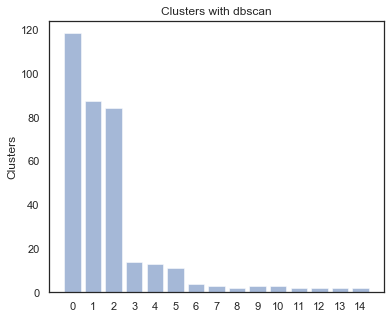

In [289]:
y_pos = np.arange(len(number_clusters))
plt.figure(figsize=(6,5))
plt.bar(y_pos, number_clusters, align='center', alpha=0.5)
plt.xticks(y_pos)
plt.ylabel('Clusters')
plt.title('Clusters with dbscan')

plt.show()

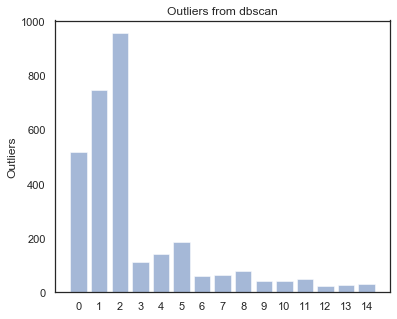

In [290]:
y_pos_out=np.arange(len(outliers))

plt.figure(figsize=(6,5))
plt.bar(y_pos_out, outliers, align='center', alpha=0.5)
plt.xticks(y_pos)
plt.ylabel('Outliers')
plt.title('Outliers from dbscan')

plt.show()

## Accuracy for kmeans 

In [148]:
from sklearn.model_selection import train_test_split,KFold

X_train, X_test, y_train, y_test = train_test_split(x_pca2, y, test_size=0.3, random_state=101)

In [166]:
#Random choice
r_c=1/6
r_c

0.16666666666666666

In [154]:
from sklearn.utils.linear_assignment_ import linear_assignment
def train_indices(ypred, y):
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))
    
    s = np.unique(ypred)
    t = np.unique(y)
    
    N = len(np.unique(ypred))
    C = np.zeros((N, N), dtype = np.int32)
    for i in range(N):
        for j in range(N):
            idx = np.logical_and(ypred == s[i], y == t[j])
            C[i][j] = np.count_nonzero(idx)
    
    # convert the C matrix to the 'true' cost
    Cmax = np.amax(C)
    C = Cmax - C
    # 
    indices = linear_assignment(C)
    return indices
   

In [152]:
def acc(indices,ypred, y):
    row = indices[:][:, 0]
    col = indices[:][:, 1]
    s = np.unique(ypred)
    t = np.unique(y)
    
    N = len(np.unique(ypred))
    C = np.zeros((N, N), dtype = np.int32)
    # calculating the accuracy according to the optimal assignment
    count = 0
    for i in range(N):
        idx = np.logical_and(ypred == s[row[i]], y == t[col[i]] )
        count += np.count_nonzero(idx)
    
    return 1.0*count/len(y)

In [167]:
KM_6 = KMeans(n_clusters = 6, max_iter = 500).fit(X_train)
# plot2dcluster(X_scaled, KM_6.labels_, y,centroids=KM_6.cluster_centers_)
pred_kmeans_train=KM_6.predict(X_train)
ind=train_indices(pred_kmeans_train,y_train)
pred_kmeans_test=KM_6.predict(X_test)
accuracy=acc(ind,pred_kmeans_test,y_test)
print(accuracy)

0.4261763115197404


C:\Users\Andreea\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [168]:
#k-means performance:
if r_c < accuracy:
    print('Accuracy bigger than random choice')
else:
     print('Accuracy smaller than random choice')

Accuracy bigger than random choice


In [171]:
results_clustering

,Algorithm,Data,Distance BC - Maximized,Distance WC - Minimised,N-clusters
0,K-Means,Raw data,2.489077e+12,7.049904e+12,3
1,K-Means,Normalized data,7.367996e+06,3.477205e+07,3
2,K-Means,2 Dimensioned data with PCA,4.996310e+06,3.311115e+07,3
3,DBSCAN,2 Dimensioned data with PCA,4.788023e+07,7.205380e+07,3
